<a href="https://colab.research.google.com/github/kosiyyu/ml/blob/main/cats_dogs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data source
https://www.microsoft.com/en-us/download/confirmation.aspx?id=54765

# Creating dataset

In [18]:
!pip install python-dotenv
!pip install awscli
!pip install boto3

In [19]:
from dotenv import load_dotenv
import os
import boto3
import numpy as np
import matplotlib.pyplot as plt
import cv2
import random

Pass .env file:

```
AWS_ACCESS_KEY_ID=
AWS_SECRET_ACCESS_KEY=
AWS_DEFAULT_REGION=
```

In [23]:
BUCKET_NAME = 'kosiyyu-eu-north-1-my-files'

load_dotenv('.env')

s3 = boto3.client('s3')

In [24]:
def list_files():
  response = s3.list_objects_v2(Bucket=BUCKET_NAME, MaxKeys=25)
  for content in response.get('Contents'):
    print(content['Key'])

def download_file(s3_filename, save_filename=None):
  if save_filename is None:
    save_filename = s3_filename
  s3.download_file(Bucket=BUCKET_NAME, Key=s3_filename, Filename=save_filename)

In [25]:
list_files()

cats_dogs_x_y_data.pkl
kagglecatsanddogs_5340.zip


In [6]:
# Uncomment line below to download source file
# download_file('kagglecatsanddogs_5340.zip')

In [7]:
!du -h kagglecatsanddogs_5340.zip

787M	kagglecatsanddogs_5340.zip


In [12]:
!unzip -q kagglecatsanddogs_5340.zip

In [15]:
DIR = 'PetImages'
CATS = DIR + '/Cat'
DOGS = DIR + '/Dog'
CATEGORIES = { CATS: 0, DOGS: 1}
IMG_SIZE = 100

print(DIR)
print(CATS)
print(DOGS)
print(CATEGORIES)
print(IMG_SIZE)

PetImages
PetImages/Cat
PetImages/Dog
{'PetImages/Cat': 0, 'PetImages/Dog': 1}
100


In [16]:
print(os.listdir(CATS)[:5])
print(os.listdir(DOGS)[:5])

['4079.jpg', '695.jpg', '3804.jpg', '1897.jpg', '11244.jpg']
['4079.jpg', '695.jpg', '3804.jpg', '1897.jpg', '11244.jpg']


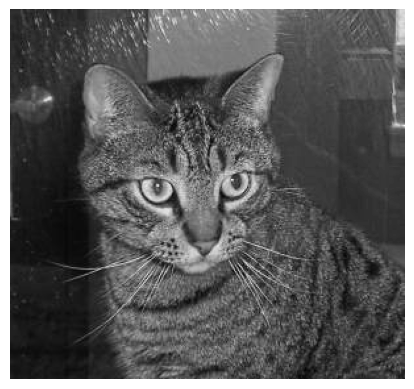

(281, 300)


In [17]:
img_array = cv2.imread(os.path.join(CATS, '1.jpg'))
img = cv2.cvtColor(img_array, cv2.COLOR_BGR2GRAY)

plt.imshow(img, cmap='gray')
plt.axis('off')
plt.show()

print(img.shape)

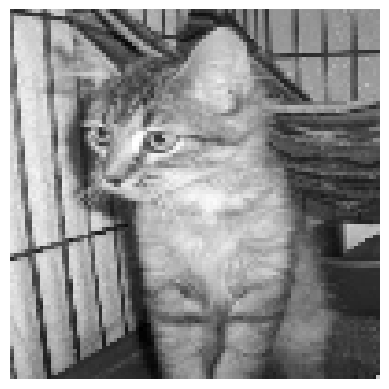

(100, 100)


In [18]:
img_array = cv2.imread(os.path.join(CATS, '2.jpg'))
flag_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
img = cv2.cvtColor(flag_array, cv2.COLOR_BGR2GRAY)

plt.imshow(img, cmap='gray')
plt.axis('off')
plt.show()

print(img.shape)

In [19]:
def create_traning_data():
    samples = []
    for path in CATEGORIES.keys():
        for name in os.listdir(path):
            try:
                updated_path = os.path.join(path, name)
                img_array = cv2.imread(updated_path)
                flag_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
                processed_array = cv2.cvtColor(flag_array, cv2.COLOR_BGR2GRAY)
                samples.append([processed_array, CATEGORIES[path]])
            except Exception as e:
                pass

    return samples

In [20]:
traning_data = create_traning_data()
len(traning_data)

24946

In [21]:
X = []
y = []

random.shuffle(traning_data)

for feature, label in traning_data:
    X.append(feature)
    y.append(label)

X = np.array(X).reshape(-1, IMG_SIZE, IMG_SIZE, 1)
y = np.array(y)

## Save data

In [22]:
import pickle

with open('cats_dogs_x_y_data.pkl', 'wb') as f:
    pickle.dump((X, y), f)

## Load data

In [5]:
import pickle

X = []
y = []

with open('cats_dogs_x_y_data.pkl', 'rb') as f:
    X, y = pickle.load(f)

In [31]:
print(len(X), len(y))

24946 24946


# Convolutional Neural Network

In [25]:
!pip install tensorflow

In [2]:
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D, Input
import tensorflow_datasets as tfds

print("TensorFlow version:", tf.__version__)
print("Available devices:", tf.config.list_physical_devices())

TensorFlow version: 2.15.0
Available devices: [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:TPU_SYSTEM:0', device_type='TPU_SYSTEM'), PhysicalDevice(name='/physical_device:TPU:0', device_type='TPU'), PhysicalDevice(name='/physical_device:TPU:1', device_type='TPU'), PhysicalDevice(name='/physical_device:TPU:2', device_type='TPU'), PhysicalDevice(name='/physical_device:TPU:3', device_type='TPU'), PhysicalDevice(name='/physical_device:TPU:4', device_type='TPU'), PhysicalDevice(name='/physical_device:TPU:5', device_type='TPU'), PhysicalDevice(name='/physical_device:TPU:6', device_type='TPU'), PhysicalDevice(name='/physical_device:TPU:7', device_type='TPU')]


## Add TPU support

In [3]:
resolver = tf.distribute.cluster_resolver.TPUClusterResolver()
# On TPU VMs use this line instead:
# resolver = tf.distribute.cluster_resolver.TPUClusterResolver(tpu="local")
tf.config.experimental_connect_to_cluster(resolver)
tf.tpu.experimental.initialize_tpu_system(resolver)

All devices:  [LogicalDevice(name='/device:TPU:0', device_type='TPU'), LogicalDevice(name='/device:TPU:1', device_type='TPU'), LogicalDevice(name='/device:TPU:2', device_type='TPU'), LogicalDevice(name='/device:TPU:3', device_type='TPU'), LogicalDevice(name='/device:TPU:4', device_type='TPU'), LogicalDevice(name='/device:TPU:5', device_type='TPU'), LogicalDevice(name='/device:TPU:6', device_type='TPU'), LogicalDevice(name='/device:TPU:7', device_type='TPU')]


In [9]:
devices = tf.config.list_physical_devices()
for device in devices:
    print(device)

PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')
PhysicalDevice(name='/physical_device:TPU_SYSTEM:0', device_type='TPU_SYSTEM')
PhysicalDevice(name='/physical_device:TPU:0', device_type='TPU')
PhysicalDevice(name='/physical_device:TPU:1', device_type='TPU')
PhysicalDevice(name='/physical_device:TPU:2', device_type='TPU')
PhysicalDevice(name='/physical_device:TPU:3', device_type='TPU')
PhysicalDevice(name='/physical_device:TPU:4', device_type='TPU')
PhysicalDevice(name='/physical_device:TPU:5', device_type='TPU')
PhysicalDevice(name='/physical_device:TPU:6', device_type='TPU')
PhysicalDevice(name='/physical_device:TPU:7', device_type='TPU')


In [6]:
X = X/255.0 # Not values will between [0, 1]

In [7]:
print(type(X), type(y))

<class 'numpy.ndarray'> <class 'numpy.ndarray'>


## Model

In [10]:
strategy = tf.distribute.TPUStrategy(resolver)

In [11]:
with strategy.scope():
  model = Sequential([
      Input(shape=X.shape[1:]),
      Conv2D(64, (3,3)),
      Activation("relu"),
      MaxPooling2D(pool_size=(2, 2)),

      Conv2D(64, (3,3)),
      Activation("relu"),
      MaxPooling2D(pool_size=(2, 2)),

      Flatten(),
      Dense(64, activation='relu'),
      Dense(1, activation='sigmoid'),
  ])

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

model.fit(X, y, batch_size=32, epochs=10, validation_split=0.1)

Epoch 1/10
702/702 [==============================] - 26s 29ms/step - loss: 0.6180 - accuracy: 0.6546 - val_loss: 0.5327 - val_accuracy: 0.7395
Epoch 2/10
702/702 [==============================] - 15s 21ms/step - loss: 0.4900 - accuracy: 0.7654 - val_loss: 0.4678 - val_accuracy: 0.7760
Epoch 3/10
702/702 [==============================] - 14s 20ms/step - loss: 0.4113 - accuracy: 0.8104 - val_loss: 0.4335 - val_accuracy: 0.7976
Epoch 4/10
702/702 [==============================] - 15s 22ms/step - loss: 0.3350 - accuracy: 0.8516 - val_loss: 0.4634 - val_accuracy: 0.7804
Epoch 5/10
702/702 [==============================] - 15s 21ms/step - loss: 0.2484 - accuracy: 0.8961 - val_loss: 0.4937 - val_accuracy: 0.7928
Epoch 6/10
702/702 [==============================] - 15s 21ms/step - loss: 0.1498 - accuracy: 0.9419 - val_loss: 0.5881 - val_accuracy: 0.7924
Epoch 7/10
702/702 [==============================] - 14s 21ms/step - loss: 0.0812 - accuracy: 0.9717 - val_loss: 0.7711 - val_accuracy:

In [26]:
model.save('cats_dogs_model.keras')

In [27]:
!ls

 cats_dogs_model.keras	  CDLA-Permissive-2.0.pdf      PetImages        sample_data
 cats_dogs_x_y_data.pkl   kagglecatsanddogs_5340.zip  'readme[1].txt'


# Showcase

In [28]:
model = load_model('cats_dogs_model.keras')

1/1 [==============================] - 0s 173ms/step
|  id: 0, real val: 1, predicted val: 0.7903680801391602
V


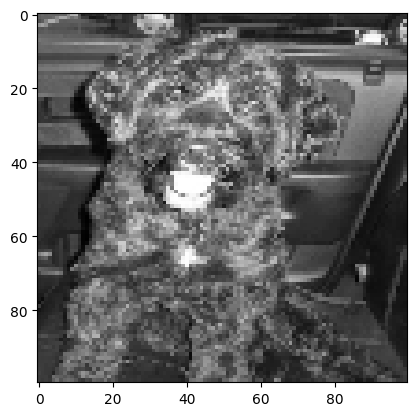

|  id: 1, real val: 1, predicted val: 0.9993113875389099
V


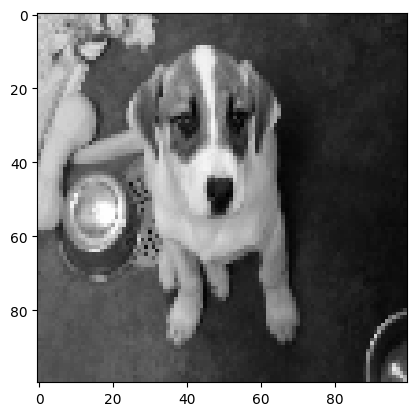

|  id: 2, real val: 1, predicted val: 0.9972391128540039
V


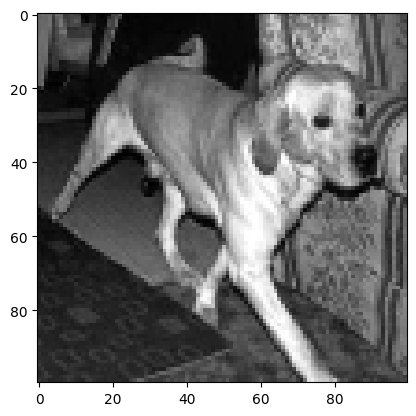

|  id: 3, real val: 1, predicted val: 0.9994813203811646
V


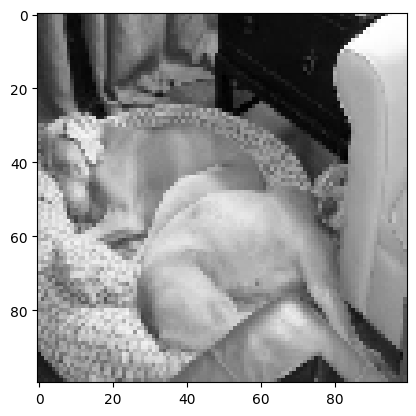

|  id: 4, real val: 1, predicted val: 1.0
V


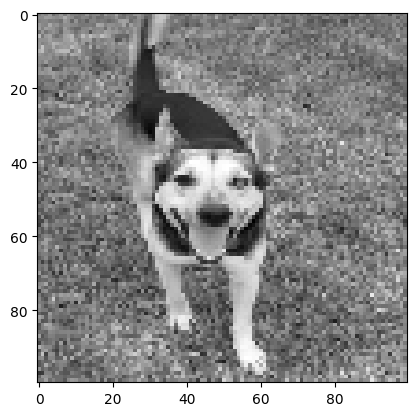

|  id: 5, real val: 1, predicted val: 0.9933111667633057
V


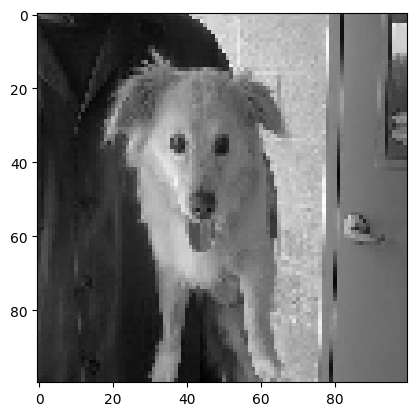

|  id: 6, real val: 0, predicted val: 0.11659431457519531
V


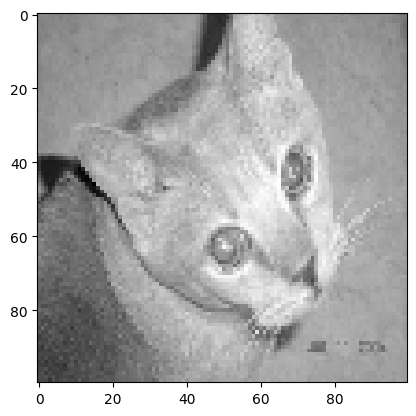

|  id: 7, real val: 0, predicted val: 0.0022273585200309753
V


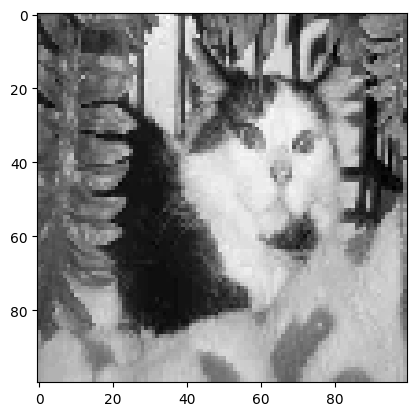

|  id: 8, real val: 1, predicted val: 0.9885708689689636
V


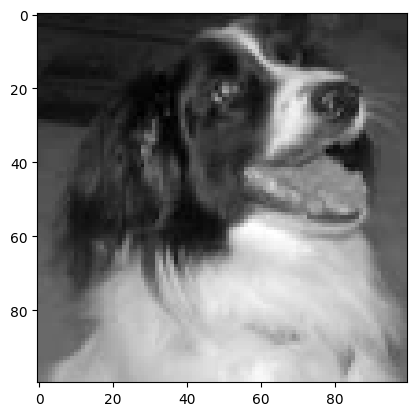

|  id: 9, real val: 1, predicted val: 0.7411353588104248
V


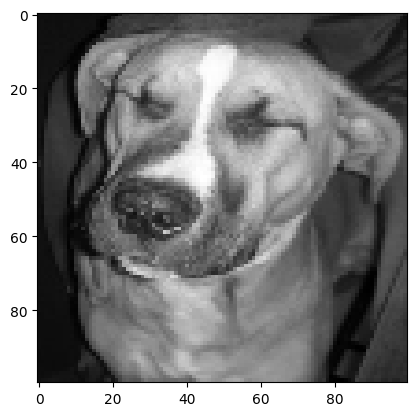

|  id: 10, real val: 0, predicted val: 6.065017259970773e-06
V


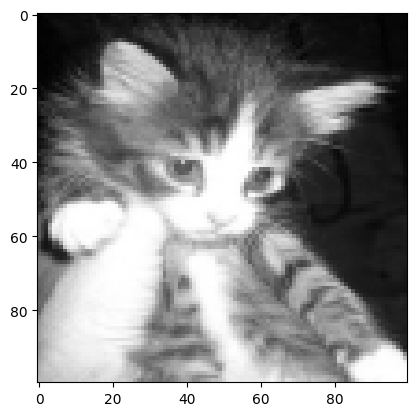

|  id: 11, real val: 1, predicted val: 0.9945142865180969
V


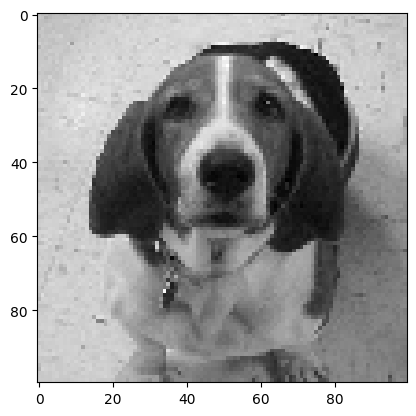

|  id: 12, real val: 1, predicted val: 0.9799103140830994
V


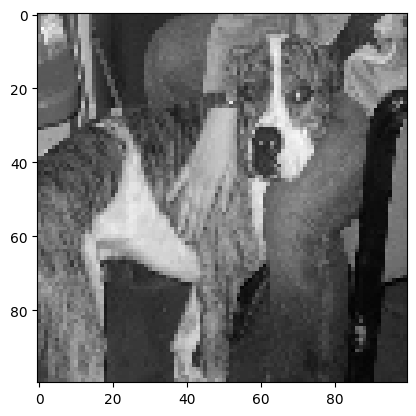

|  id: 13, real val: 1, predicted val: 0.7722257375717163
V


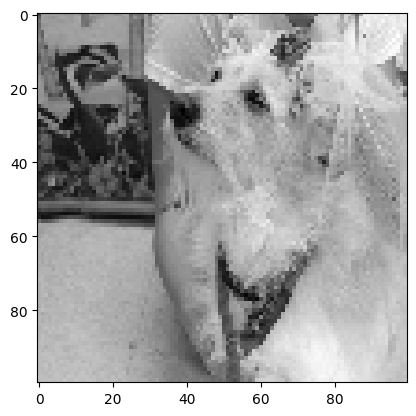

|  id: 14, real val: 1, predicted val: 0.942911684513092
V


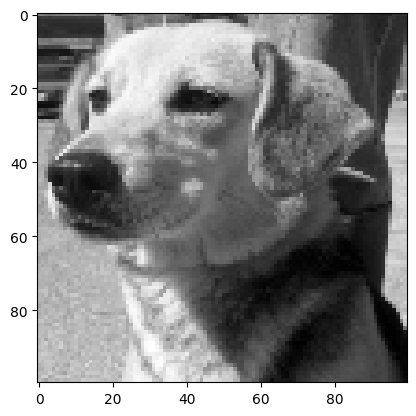

|  id: 15, real val: 0, predicted val: 0.004640778061002493
V


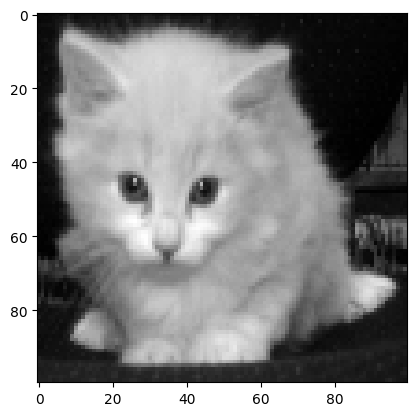

|  id: 16, real val: 1, predicted val: 0.9993398189544678
V


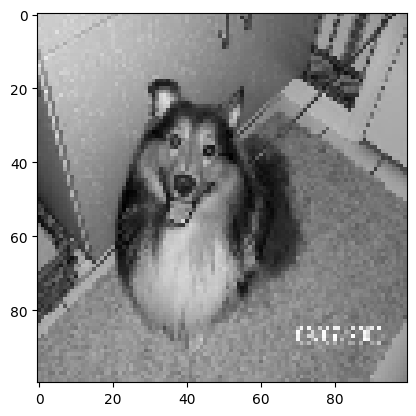

|  id: 17, real val: 1, predicted val: 0.9997640252113342
V


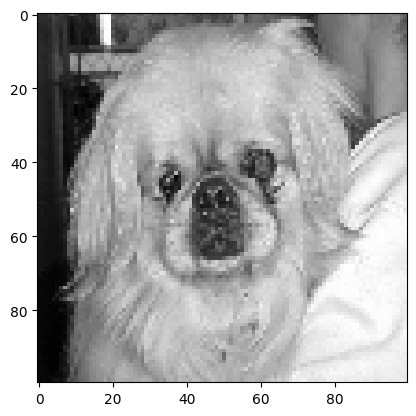

|  id: 18, real val: 0, predicted val: 2.602802624096512e-06
V


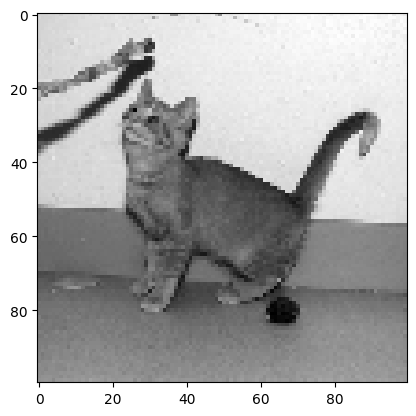

|  id: 19, real val: 1, predicted val: 0.9980433583259583
V


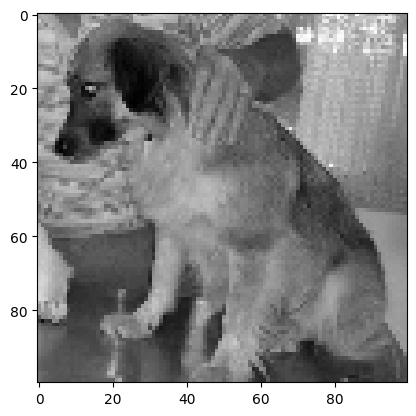

In [29]:
predictions = model.predict(X[:20])

for i in range(0, 20):
  print('|', f' id: {i}, real val: {y[i]}, predicted val: {predictions[i].item()}')
  print('V')
  plt.imshow(X[i], cmap='gray')
  plt.show()